In [1]:
import os
import sys, re
from datetime import datetime, timedelta
import numpy as np
from netCDF4 import Dataset
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

warnings.filterwarnings(action='ignore')

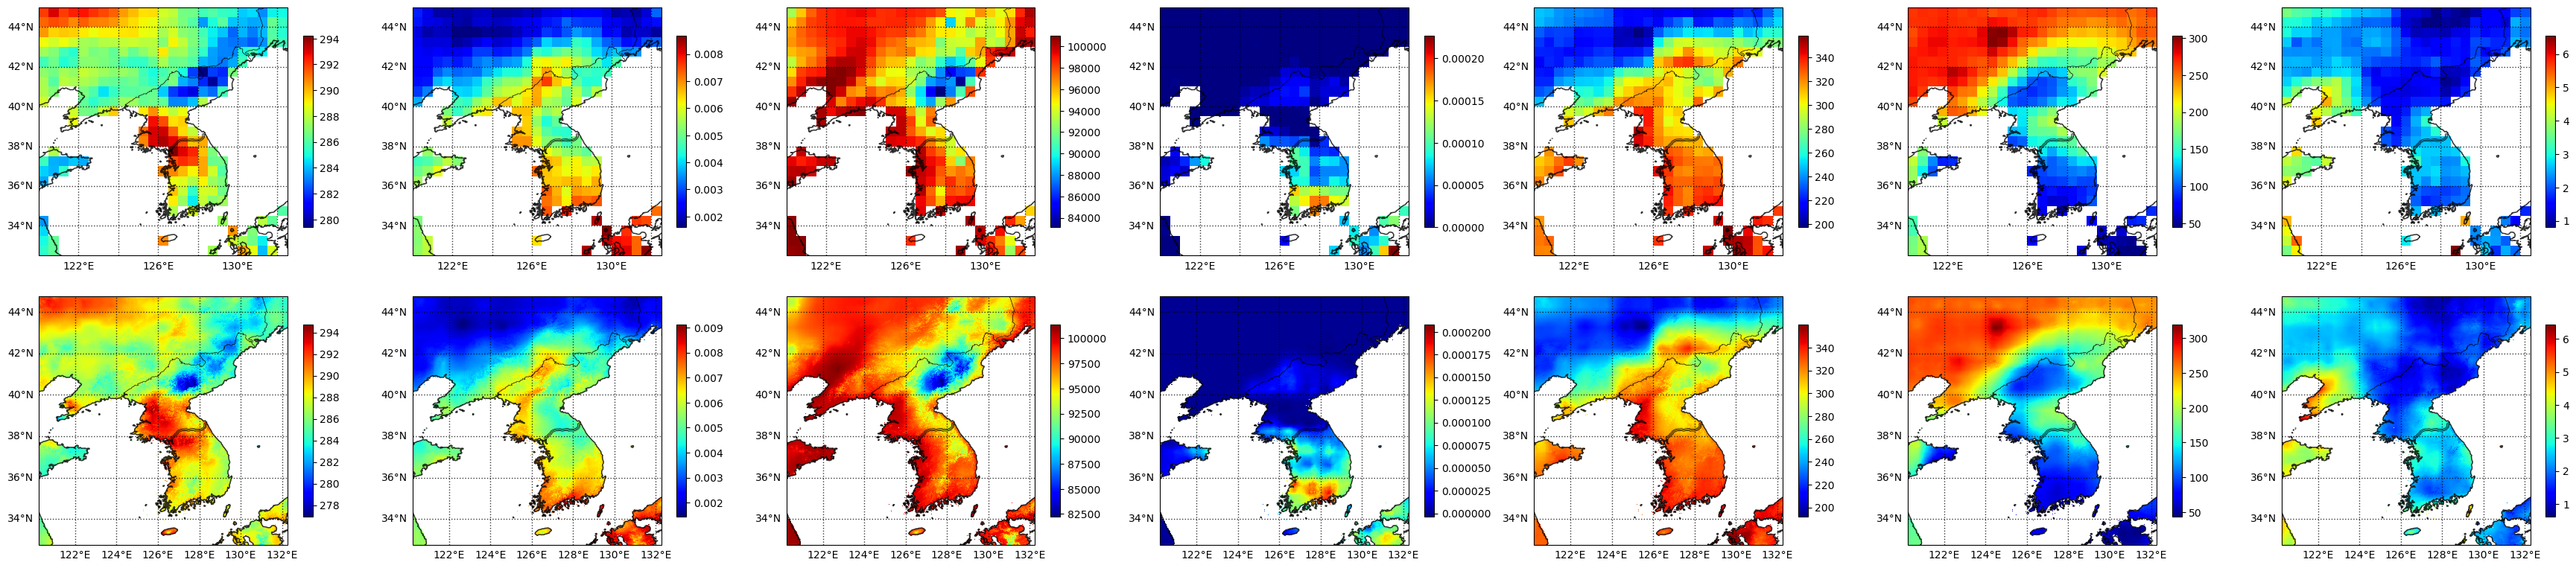

In [2]:
aa = np.load("/lustre/home/ebcho/workspace/pyfwi/SR_ISIMIP/result/historical/IPSL-CM6A-LR/liif_25/preds_2000.npy", mmap_mode='r')
bb = Dataset("/lustre/home/eunhan/korea_downscaling_2km/historical2/IPSL-CM6A-LR/2000.nc", 'r', format = 'netcdf4')

var_names = ['tasmax', 'huss', 'ps', 'pr', 'rlds', 'rsds', 'sfcwind']
data = []
for var in var_names:
    data.append(bb.variables[var][100, :, :])  # shape: (25, 25)

# (7, 25, 25) 배열로 스택
result = np.stack(data, axis=0)

row, col = 2, 7
p = ccrs.PlateCarree()
fig, axes = plt.subplots(row, col, figsize=(col * 5, row * 4), subplot_kw={'projection': p})
axes = axes.flatten()

datas = [result, aa[100]]  # 각 data shape: (7, lat, lon)
lat_list = [
    np.load("../../data/ISIMIP_ko_lat_0p50deg.npy"),
    np.load("../../data/ISIMIP_ko_lat_2km.npy")
]
lon_list = [
    np.load("../../data/ISIMIP_ko_lon_0p50deg.npy"),
    np.load("../../data/ISIMIP_ko_lon_2km.npy")
]
lsm_list = [
    np.load("../../data/land_sea_mask_0p50deg.npy"),
    np.load("../../data/land_sea_mask_2km.npy")
]

# data_names = ["O (0.5°)", "다운스케일링 결과 (2km)"]

for data_idx, (data_npy, lat, lon, lsm) in enumerate(zip(datas, lat_list, lon_list, lsm_list)):
    for var_idx in range(7):
        ax = axes[data_idx * 7 + var_idx]
        val_data = np.where(lsm, data_npy[var_idx], np.nan)#data_npy[var_idx]
        if data_idx == 1:
            val_data = np.flipud(val_data)

        # 위도, 경도 mesh 확인
        lon_grid, lat_grid = np.meshgrid(lon, lat)

        c = ax.pcolormesh(lon_grid, lat_grid, val_data, transform=p, cmap='jet', shading='auto')

        ax.coastlines(color="black", linewidth=1.1, alpha=0.8)
        ax.add_feature(cf.BORDERS, linewidth=0.5, edgecolor='black')

        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color="black", alpha=0.8, linestyle=':', linewidth=1.0)
        gl.top_labels = False
        gl.right_labels = False

        fig.colorbar(c, ax=ax, orientation="vertical", shrink=0.7)
        # ax.set_title(f"{label} - var{var_idx + 1}")

plt.tight_layout()
plt.show()
